# Access Database-Files to explore and summerise Data

In [3]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [4]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [72]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-11-01/data_eval_new/"
file_name = "int_norm_20161101_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [73]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [74]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [75]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

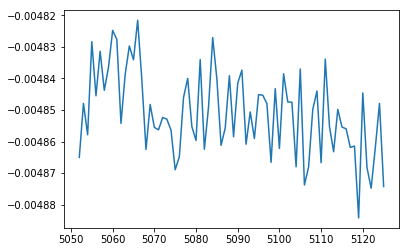

In [76]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

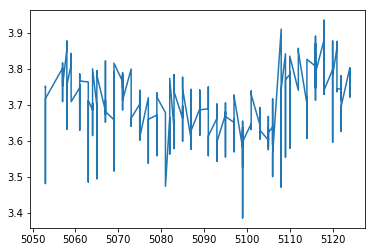

In [77]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

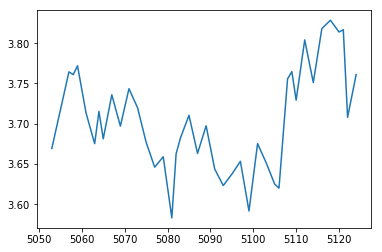

In [78]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

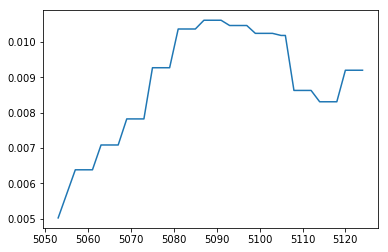

In [79]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [80]:
background_mean = df_mean(background)

# Outlier rejection

In [169]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [170]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [171]:
column = "124/118"
sample = "NIST 200ppb"

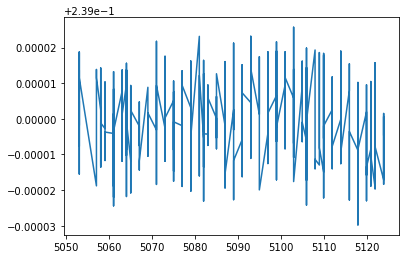

In [172]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [173]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [174]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-10-31 22:56:00,NIST 200ppb,2,1,5053,0.040153,NaN,0.013947,0.600314,0.316749,0.354652,1.345915,0.19125,0.239013
2016-10-31 22:56:00,NIST 200ppb,2,2,5053,0.040146,0.027178,0.013947,0.600272,0.316753,0.354653,1.345899,0.19125,0.238998
2016-10-31 22:56:00,NIST 200ppb,2,3,5053,0.040151,0.027179,0.013946,0.600291,0.316752,0.354649,1.345927,NaN,0.238998
2016-10-31 22:56:00,NIST 200ppb,2,4,5053,0.040149,0.027179,0.013948,0.600323,0.316767,0.354649,1.345916,NaN,0.239004
2016-10-31 22:56:00,NIST 200ppb,2,5,5053,0.040145,0.027175,0.013949,0.600309,0.316757,0.354658,1.345917,NaN,0.238998
2016-10-31 22:56:00,NIST 200ppb,2,6,5053,0.040145,0.027177,0.013948,0.600305,0.316763,0.354657,1.345949,0.19125,0.239005
2016-10-31 22:56:00,NIST 200ppb,2,7,5053,0.040147,0.027176,0.013947,0.600321,0.316766,0.354648,1.345920,NaN,0.238992
2016-10-31 22:56:00,NIST 200ppb,2,8,5053,0.040140,0.027177,0.013948,0.600294,0.316754,0.354656,1.345936,0.19125,0.239009
2016-10-31 22:56:00,NIST 200ppb,2,9,5053,0.040148,0.027176,0.013950,0.600298,0.316759,0.354659,1.345960,0.19125,0.239003


In [175]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
5063        2016-11-01 01:11:00    0.258881
5073        2016-11-01 03:33:00    0.259142
5075        2016-11-01 03:59:00    0.259375
            2016-11-01 03:59:00    0.259358
5079        2016-11-01 04:57:00    0.259352
5090        2016-11-01 07:30:00    0.259279
5100        2016-11-01 09:48:00    0.259438
            2016-11-01 09:48:00    0.259446
5109        2016-11-01 13:29:00    0.258912
5114        2016-11-01 14:39:00    0.259251
5115        2016-11-01 14:53:00    0.259071
5116        2016-11-01 15:08:00    0.258975
5118        2016-11-01 15:37:00    0.258682
            2016-11-01 15:37:00    0.258668
Name: 124/118, dtype: float64

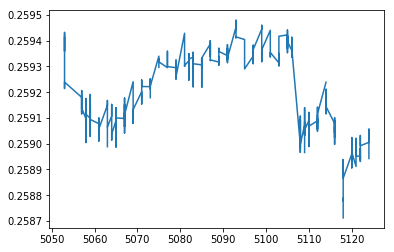

In [176]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [177]:
df[df["Sample"] == sample][column].std()

0.00015471894221380994

In [178]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

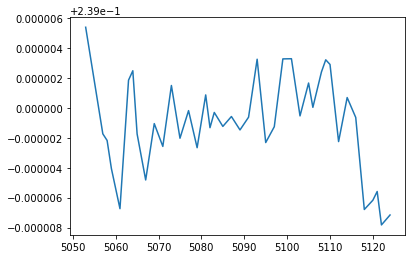

In [179]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [180]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-10-31 22:56:00,5053,NIST 200ppb,0.040145,0.027175,0.013948,0.600298,0.316757,0.354651,1.345939,0.19125,0.239005
2016-10-31 23:22:00,5055,NIST 350ppb,0.040151,0.027180,0.013949,0.600332,0.316768,0.354654,1.345963,0.19125,0.238998
2016-10-31 23:48:00,5057,NIST 200ppb,0.040149,0.027177,0.013948,0.600316,0.316756,0.354643,1.345951,0.19125,0.238998
2016-11-01 00:02:00,5058,NIST 200ppb,0.040148,0.027179,0.013947,0.600310,0.316751,0.354641,1.345953,0.19125,0.238998
2016-11-01 00:17:00,5059,NIST 200ppb,0.040147,0.027177,0.013947,0.600316,0.316753,0.354642,1.345959,0.19125,0.238996
2016-11-01 00:31:00,5060,NIST 350ppb,0.040151,0.027181,0.013949,0.600347,0.316766,0.354646,1.345968,0.19125,0.238993
2016-11-01 00:46:00,5061,NIST 200ppb,0.040151,0.027179,0.013949,0.600322,0.316755,0.354641,1.345960,0.19125,0.238993
2016-11-01 01:11:00,5063,NIST 200ppb,0.040147,0.027177,0.013949,0.600323,0.316753,0.354643,1.345962,0.19125,0.239002
2016-11-01 01:26:00,5064,NIST 200ppb,0.040149,0.027179,0.013948,0.600326,0.316751,0.354642,1.345964,0.19125,0.239002


In [181]:
date_list = [pd.Timestamp("2016-11-01 10:57:00"), 
            pd.Timestamp("2016-11-01 11:12:00")]
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [182]:
drop_sum = [pd.Timestamp("2016-10-31 22:56:00")]

In [183]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [184]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [185]:
data_mean_int_sum

112/118                   114/118                  \
                               mean       SD2 count      mean       SD2 count   
Sample                                                                          
Allende bomb 2_2           0.040145       NaN     1  0.027179       NaN     1   
NIST 1000ng Sn TRU + PRE   0.040147       NaN     1  0.027178       NaN     1   
NIST 200ppb                0.040150  0.000005    38  0.027179  0.000002    38   
NIST 200ppb + 0.005ppb U   0.040153       NaN     1  0.027182       NaN     1   
NIST 200ppb + 0.015ppb U   0.040152       NaN     1  0.027179       NaN     1   
NIST 200ppb + 0.030ppb Cd  0.040153       NaN     1  0.027183       NaN     1   
NIST 200ppb + 0.04ppb Cd   0.040155       NaN     1  0.027187       NaN     1   
NIST 200ppb + 0.100ppb Zr  0.040152       NaN     1  0.027178       NaN     1   
NIST 200ppb + 0.150ppb Rh  0.040154       NaN     1  0.027178       NaN     1   
NIST 200ppb + 0.250ppb Pd  0.040152       NaN     1  0.027180       NaN     1   
NIST 200ppb + 0.300ppb Ru  0.040153       NaN     1  0.027180       NaN     1   
NIST 200ppb + 0.800ppb Mo  0.040151       NaN     1  0.027181       NaN     1   
NIST 200ppb + ME           0.040152       NaN     1  0.027182       NaN     1   
NIST 350ppb                0.040152  0.000003     6  0.027181  0.000001     6   

                            115/118                   116/118  ...  119/118  \
                               mean       SD2 count      mean  ...    count   
Sample                                                         ...            
Allende bomb 2_2           0.013946       NaN     1  0.600326  ...        1   
NIST 1000ng Sn TRU + PRE   0.013948       NaN     1  0.600333  ...        1   
NIST 200ppb                0.013948  0.000002    38  0.600334  ...       38   
NIST 200ppb + 0.005ppb U   0.013949       NaN     1  0.600335  ...        1   
NIST 200ppb + 0.015ppb U   0.013948       NaN     1  0.600343  ...        1   
NIST 200ppb + 0.030ppb Cd  0.013951       NaN     1  0.600334  ...        1   
NIST 200ppb + 0.04ppb Cd   0.013948       NaN     1  0.600340  ...        1   
NIST 200ppb + 0.100ppb Zr  0.013948       NaN     1  0.600341  ...        1   
NIST 200ppb + 0.150ppb Rh  0.013949       NaN     1  0.600349  ...        1   
NIST 200ppb + 0.250ppb Pd  0.013949       NaN     1  0.600341  ...        1   
NIST 200ppb + 0.300ppb Ru  0.013948       NaN     1  0.600340  ...        1   
NIST 200ppb + 0.800ppb Mo  0.013948       NaN     1  0.600338  ...        1   
NIST 200ppb + ME           0.013948       NaN     1  0.600343  ...        1   
NIST 350ppb                0.013949  0.000001     6  0.600354  ...        6   

                            120/118                  122/118                \
                               mean       SD2 count     mean           SD2   
Sample                                                                       
Allende bomb 2_2           1.345963       NaN     1  0.19125           NaN   
NIST 1000ng Sn TRU + PRE   1.345984       NaN     1  0.19125           NaN   
NIST 200ppb                1.345968  0.000017    38  0.19125  1.524339e-16   
NIST 200ppb + 0.005ppb U   1.345968       NaN     1  0.19125           NaN   
NIST 200ppb + 0.015ppb U   1.345970       NaN     1  0.19125           NaN   
NIST 200ppb + 0.030ppb Cd  1.345974       NaN     1  0.19125           NaN   
NIST 200ppb + 0.04ppb Cd   1.345976       NaN     1  0.19125           NaN   
NIST 200ppb + 0.100ppb Zr  1.345964       NaN     1  0.19125           NaN   
NIST 200ppb + 0.150ppb Rh  1.345975       NaN     1  0.19125           NaN   
NIST 200ppb + 0.250ppb Pd  1.345966       NaN     1  0.19125           NaN   
NIST 200ppb + 0.300ppb Ru  1.345974       NaN     1  0.19125           NaN   
NIST 200ppb + 0.800ppb Mo  1.345974       NaN     1  0.19125           NaN   
NIST 200ppb + ME           1.345970       NaN     1  0.19125           NaN   
NIST 350ppb                1.345973  0.000018     6  0.191

In [186]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [187]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-10-31 22:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 200ppb
2016-10-31 23:22:00,0.000000,0.974121,1.481558,0.310629,0.415875,0.377299,0.183527,0.134568,0.000000e+00,-0.146090,NIST 350ppb
2016-10-31 23:48:00,2.967066,0.652397,0.110967,0.608623,0.206158,0.038970,-0.081110,0.039548,2.220446e-12,-0.139589,NIST 200ppb
2016-11-01 00:02:00,0.000000,0.000939,0.713242,-0.811231,-0.113126,-0.099058,-0.041828,-0.016999,-3.330669e-12,0.029953,NIST 200ppb
2016-11-01 00:17:00,-0.988240,-0.644535,-0.862582,-0.412285,0.012087,-0.001060,0.023464,0.016632,0.000000e+00,0.016860,NIST 200ppb
2016-11-01 00:31:00,0.000000,0.557589,1.027018,0.402483,0.460576,0.369944,0.127119,0.068156,-3.330669e-12,-0.069615,NIST 350ppb
2016-11-01 00:46:00,0.000000,1.017752,0.850432,0.913946,0.034476,0.066953,-0.033186,-0.002568,2.220446e-12,-0.235529,NIST 200ppb
2016-11-01 01:11:00,0.987654,-0.775698,-0.784400,-0.158268,-0.019349,-0.002427,0.026093,0.002594,0.000000e+00,0.166308,NIST 200ppb
2016-11-01 01:26:00,0.000000,0.000191,0.451565,-0.026699,0.038262,-0.009480,0.001520,0.046878,-1.110223e-12,0.101393,NIST 200ppb


In [188]:

date_list = [pd.Timestamp("2016-10-31 23:22:00"), 
             pd.Timestamp("2016-10-31 23:48:00")]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [189]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -20) & (df["Filenumber"] <= 20)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [190]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [191]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-11-01 00:02:00,5058,0.000939,0.713242,-0.811231,-0.113126,-0.099058,-0.041828,-0.016999,-3.330669e-12,0.029953,NIST 200ppb
2016-11-01 00:17:00,5059,-0.644535,-0.862582,-0.412285,0.012087,-0.001060,0.023464,0.016632,0.000000e+00,0.016860,NIST 200ppb
2016-11-01 00:31:00,5060,0.557589,1.027018,0.402483,0.460576,0.369944,0.127119,0.068156,-3.330669e-12,-0.069615,NIST 350ppb
2016-11-01 00:46:00,5061,1.017752,0.850432,0.913946,0.034476,0.066953,-0.033186,-0.002568,2.220446e-12,-0.235529,NIST 200ppb
2016-11-01 01:11:00,5063,-0.775698,-0.784400,-0.158268,-0.019349,-0.002427,0.026093,0.002594,0.000000e+00,0.166308,NIST 200ppb
2016-11-01 01:26:00,5064,0.000191,0.451565,-0.026699,0.038262,-0.009480,0.001520,0.046878,-1.110223e-12,0.101393,NIST 200ppb
2016-11-01 01:40:00,5065,-0.177503,-0.380348,-0.074154,-0.049141,-0.041892,0.083477,-0.092948,2.220446e-12,-0.023954,NIST 200ppb
2016-11-01 01:55:00,5066,-0.406499,-0.047098,0.344981,0.410130,0.448687,0.150529,0.109914,0.000000e+00,-0.013452,NIST 350ppb
2016-11-01 02:09:00,5067,0.817893,0.256081,0.001105,0.052184,0.039661,-0.139907,0.056463,-3.330669e-12,-0.142990,NIST 200ppb


In [192]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [193]:
epsilon_sum_all

112/118              114/118              115/118  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
Allende bomb 2_2           -0.335    NaN     1   0.421    NaN     1  -2.299   
NIST 1000ng Sn TRU + PRE   -0.383    NaN     1  -0.047    NaN     1  -0.933   
NIST 200ppb                -0.008  0.899    36   0.000  0.910    36  -0.030   
NIST 200ppb + 0.005ppb U    0.163    NaN     1   0.581    NaN     1   0.069   
NIST 200ppb + 0.015ppb U    0.007    NaN     1  -0.462    NaN     1  -0.103   
NIST 200ppb + 0.030ppb Cd   0.166    NaN     1   1.184    NaN     1   1.497   
NIST 200ppb + 0.04ppb Cd    0.749    NaN     1   2.437    NaN     1   0.495   
NIST 200ppb + 0.100ppb Zr   0.364    NaN     1  -0.424    NaN     1   0.045   
NIST 200ppb + 0.150ppb Rh   0.421    NaN     1  -0.197    NaN     1   0.372   
NIST 200ppb + 0.250ppb Pd   0.160    NaN     1  -0.015    NaN     1   0.689   
NIST 200ppb + 0.300ppb Ru   0.076    NaN     1   0.428    NaN     1  -0.685   
NIST 200ppb + 0.800ppb Mo  -0.218    NaN     1  -0.197    NaN     1   0.015   
NIST 200ppb + ME            0.331    NaN     1   1.289    NaN     1   0.601   
NIST 350ppb                 0.458  1.042     5   0.634  0.991     5   0.337   

                                       116/118  ...  119/118 120/118         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
Allende bomb 2_2             NaN     1  -0.100  ...        1  -0.098    NaN   
NIST 1000ng Sn TRU + PRE     NaN     1  -0.048  ...        1   0.043    NaN   
NIST 200ppb                0.957    36  -0.002  ...       36  -0.001  0.079   
NIST 200ppb + 0.005ppb U     NaN     1  -0.079  ...        1   0.030    NaN   
NIST 200ppb + 0.015ppb U     NaN     1   0.068  ...        1  -0.023    NaN   
NIST 200ppb + 0.030ppb Cd    NaN     1  -0.078  ...        1   0.059    NaN   
NIST 200ppb + 0.04ppb Cd     NaN     1   0.026  ...        1  -0.005    NaN   
NIST 200ppb + 0.100ppb Zr    NaN     1  -0.024  ...        1  -0.045    NaN   
NIST 200ppb + 0.150ppb Rh    NaN     1   0.113  ...        1   0.052    NaN   
NIST 200ppb + 0.250ppb Pd    NaN     1   0.107  ...        1   0.006    NaN   
NIST 200ppb + 0.300ppb Ru    NaN     1   0.012  ...        1   0.046    NaN   
NIST 200ppb + 0.800ppb Mo    NaN     1   0.096  ...        1   0.064    NaN   
NIST 200ppb + ME             NaN     1   0.076  ...        1   0.018    NaN   
NIST 350ppb                0.952     5   0.451  ...        5   0.044  0.092   

                                122/118            124/118               
                          count    mean  SD2 count    mean    SD2 count  
Sample                                                                   
Allende bomb 2_2              1     0.0  NaN     1  -0.227    NaN     1  
NIST 1000ng Sn TRU + PRE      1    -0.0  NaN     1  -0.128    NaN     1  
NIST 200ppb                  36     0.0  0.0    36  -0.001  0.218    36  
NIST 200ppb + 0.005ppb U      1     0.0  NaN     1   0.078    NaN     1  
NIST 200ppb + 0.015ppb U      1    -0.0  NaN     1  -0.029    NaN     1  
NIST 200ppb + 0.030ppb Cd     1     0.0  NaN     1   0.102    NaN     1  
NIST 200ppb + 0.04ppb Cd      1     0.0  NaN     1  -0.046    NaN     1  
NIST 200ppb + 0.100ppb Zr     1    -0.0  NaN     1   0.029    NaN     1  
NIST 200ppb + 0.150ppb Rh     1     0.0  NaN     1   0.042    NaN     1  
NIST 200ppb + 0.250ppb Pd     1     0.0  NaN     1   0.026    NaN     1  
NIST 200ppb + 0.300ppb Ru     1    -0.0  NaN     1   0.042    NaN     1  
NIST 200ppb + 0.800ppb Mo     1    -0.0  NaN     1   0.313    NaN     1  
NIST 200ppb + ME              1     0.0  NaN     1   0.012    NaN     1  
NIST 350ppb                   5     0.0  0.0     5  -0.109  0.258     5  

[14 rows x 27 columns]

In [244]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [106]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [107]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [166]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [167]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [168]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [194]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')